In [1]:
%load_ext autoreload
%autoreload 1

import json
import os
import pickle
import time
import timeit
import random
import socket
import struct
import random

import numpy as np
import pandas as pd
import networkx as nx

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

from src.calculate_FPR_FNR import calculate_FPR_FNR_with_global
from src.dataset.dataset_info import datasets, cn_measures, network_features
import src.models as models
# from src.models import EGAT, EGCN, EGRAPHSAGE, Model
from src.plot_confusion_matrix import plot_confusion_matrix
from src.graph.centralities.add_centralities import add_centralities
from src.graph.graph_measures import calculate_graph_measures, find_communities
from src.numpy_encoder import NumpyEncoder

seed = 42  # or any constant value
random.seed(seed)
np.random.seed(seed)
th.manual_seed(seed)

%aimport src.models

num_epochs = 30
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001
validation_size = 0.1
test_size = 0.1

In [2]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017_5_percent"
# name = "cic_ids_2017"
name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

with_centralities = False
centralities_set = 1

multi_class = True

# dataset properties
use_port_in_address = False
generated_ips = False

graph_type = "flow"
# graph_type = "line"

using_masking = False
masked_class = 2

sort_timestamp = False

sort_after_partition = True
sequence_length = 1
stride = 1

dataset = datasets[name]

dataset_folder = os.path.join("datasets", name)
dataset_folder

'datasets\\cic_bot_iot'

In [3]:
labels = ["Normal", "Attack"]
num_classes = 2
if multi_class:
    with open(os.path.join(dataset_folder, "labels_names.pkl"), "rb") as f:
        labels_names = pickle.load(f)
    labels_mapping = labels_names[0]
    # labels = labels_names[1]
    labels = list(labels_mapping.values())
    num_classes = len(labels)
labels, num_classes

([np.str_('Benign'),
  np.str_('DDoS'),
  np.str_('DoS'),
  np.str_('Reconnaissance'),
  np.str_('Theft')],
 5)

In [4]:
out_channels_list = [64]
rnn_num_layers = 2
rnn_hidden_size = 80
dropout=0.3

In [5]:
exp_type = f"gdlc__{graph_type}"
    
if multi_class:
    exp_type += "__multi_class"
    
# if k_fold:
#     exp_type += f"__{k_fold}_fold"
    
if use_port_in_address:
    exp_type += "__ports"
    
if generated_ips:
    exp_type += "__generated_ips"
    
if sort_timestamp:
    exp_type += "__sorted"
elif sort_after_partition:
    exp_type += "__semisorted"
else:
    exp_type += "__unsorted"

In [6]:
results_final = {}

results_final["name"] = name
results_final["framework"] = "pytorch"
results_final["exp_type"] = exp_type
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "with_centralities": with_centralities,
    "centralities_set": centralities_set,
    "use_port_in_address": use_port_in_address,
    "generated_ips": generated_ips,
    "using_masking": using_masking,
    "masked_class_num": masked_class,
    "sequence_length": sequence_length,
    "LAMBD_1": LAMBD_1,
    "LAMBD_2": LAMBD_2
}

results_final["accuracy"] = {}
results_final["f1_score"] = {}
results_final["FPR"] = {}
results_final["FNR"] = {}
results_final["time_elapsed"] = {}
results_final["train_accuracy"] = {}
results_final["train_loss"] = {}
results_final["val_accuracy"] = {}
results_final["val_loss"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}


results_final

{'name': 'cic_bot_iot',
 'framework': 'pytorch',
 'exp_type': 'gdlc__flow__multi_class__semisorted',
 'configuration': {'num_epochs': 30,
  'multi_class': True,
  'batch_size': 128,
  'learning_rate': 0.1,
  'with_centralities': False,
  'centralities_set': 1,
  'use_port_in_address': False,
  'generated_ips': False,
  'using_masking': False,
  'masked_class_num': 2,
  'sequence_length': 1,
  'LAMBD_1': 0.0001,
  'LAMBD_2': 0.001},
 'accuracy': {},
 'f1_score': {},
 'FPR': {},
 'FNR': {},
 'time_elapsed': {},
 'train_accuracy': {},
 'train_loss': {},
 'val_accuracy': {},
 'val_loss': {},
 'val_precision': {},
 'val_recall': {},
 'val_f1': {},
 'val_FPR': {},
 'val_FNR': {}}

In [7]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20250122-210005'

In [8]:
results_folder_path = "results"
results_folder_path1 = os.path.join(results_folder_path, name)
results_folder_path2 = os.path.join(results_folder_path1, f"pytorch_{exp_type}")
folder_path = os.path.join(results_folder_path2, dtime)
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
os.makedirs(confusion_matrices_path, exist_ok=True)
os.makedirs("temp", exist_ok=True)

In [9]:
if using_masking:
    results_final["configuration"]["masked_class_name"] = str(labels[masked_class])

In [10]:
new_folder_path = os.path.join(dataset_folder, exp_type)
temp_folder_path = os.path.join(dataset_folder, exp_type + "_temp")

In [11]:
partitioned = os.path.isfile(f"{temp_folder_path}/train.pkl") and os.path.isfile(f"{temp_folder_path}/val.pkl") and os.path.isfile(f"{temp_folder_path}/test.pkl")
partitioned

False

In [12]:
calculated_centralities = os.path.isfile(os.path.join(new_folder_path, "training.parquet")) and os.path.isfile(os.path.join(new_folder_path, "validation.parquet")) and os.path.isfile(os.path.join(new_folder_path, "testing.parquet"))
calculated_centralities

False

In [13]:
if calculated_centralities:
    X_train = pd.read_parquet(os.path.join(new_folder_path, "training.parquet"))
    X_val = pd.read_parquet(os.path.join(new_folder_path, "validation.parquet"))
    X_test = pd.read_parquet(os.path.join(new_folder_path, "testing.parquet"))
elif partitioned:
    with open(os.path.join(temp_folder_path, "train.pkl"), "rb") as f:
        X_train, G_train, G1_train, communities_train, part_train = pickle.load(f)

    with open(os.path.join(temp_folder_path, "val.pkl"), "rb") as f:
        X_val, G_val, G1_val, communities_val, part_val = pickle.load(f)

    with open(os.path.join(temp_folder_path, "test.pkl"), "rb") as f:
        X_test, G_test, G1_test, communities_test, part_test = pickle.load(f)
elif with_centralities:
    df = pd.read_parquet(os.path.join(dataset_folder, f"{name}.parquet"))
    if generated_ips:
        df[dataset.src_ip_col] = df[dataset.src_ip_col].apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
    if sort_timestamp:
        df[dataset.timestamp_col] = pd.to_datetime(df[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        df.sort_values(dataset.timestamp_col, inplace=True)
    if use_port_in_address:
        df[dataset.src_port_col] = df[dataset.src_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.src_ip_col] = df[dataset.src_ip_col] + ':' + df[dataset.src_port_col]

        df[dataset.dst_port_col] = df[dataset.dst_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.dst_ip_col] = df[dataset.dst_ip_col] + ':' + df[dataset.dst_port_col]
    if multi_class:
        y = df[dataset.class_num_col]
    else:
        y = df[dataset.label_col]

    if sort_timestamp:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size)
    else:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size, random_state=13, stratify=y)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size, random_state=13, stratify=y_tr)

    del df

    if sort_after_partition:
        X_train[dataset.timestamp_col] = pd.to_datetime(X_train[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        X_train.sort_values(dataset.timestamp_col, inplace=True)

        X_val[dataset.timestamp_col] = pd.to_datetime(X_val[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        X_val.sort_values(dataset.timestamp_col, inplace=True)
        
        X_test[dataset.timestamp_col] = pd.to_datetime(X_test[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        X_test.sort_values(dataset.timestamp_col, inplace=True)

    if using_masking:
        X_train = X_train[X_train[dataset.class_num_col] != masked_class]

    G_train = nx.from_pandas_edgelist(
        X_train, source=dataset.src_ip_col, target=dataset.dst_ip_col, create_using=nx.DiGraph)
    G_train.remove_nodes_from(list(nx.isolates(G_train)))
    for node in G_train.nodes():
        G_train.nodes[node]['label'] = node
    G1_train, part_train, communities_train = find_communities(G_train, verbose=True)
    calculate_graph_measures(G_train, communities=communities_train, verbose=True)

    G_val = nx.from_pandas_edgelist(
        X_val, source=dataset.src_ip_col, target=dataset.dst_ip_col, create_using=nx.DiGraph)
    G_val.remove_nodes_from(list(nx.isolates(G_val)))
    for node in G_val.nodes():
        G_val.nodes[node]['label'] = node
    G1_val, part_val, communities_val = find_communities(G_val, verbose=True)
    calculate_graph_measures(G_val, communities=communities_val, verbose=True)

    G_test = nx.from_pandas_edgelist(
        X_test, source=dataset.src_ip_col, target=dataset.dst_ip_col, create_using=nx.DiGraph)
    G_test.remove_nodes_from(list(nx.isolates(G_test)))
    for node in G_test.nodes():
        G_test.nodes[node]['label'] = node
    G1_test, part_test, communities_test = find_communities(G_test, verbose=True)
    calculate_graph_measures(G_test, communities=communities_test, verbose=True)

    os.makedirs(temp_folder_path, exist_ok=True)

    with open(os.path.join(temp_folder_path, "train.pkl"), "wb") as f:
        pickle.dump((X_train, G_train, G1_train, communities_train, part_train), f)

    with open(os.path.join(temp_folder_path, "val.pkl"), "wb") as f:
        pickle.dump((X_val, G_val, G1_val, communities_val, part_val), f)

    with open(os.path.join(temp_folder_path, "test.pkl"), "wb") as f:
        pickle.dump((X_test, G_test, G1_test, communities_test, part_test), f)

else:
    df = pd.read_parquet(os.path.join(dataset_folder, f"{name}.parquet"))
    if generated_ips:
        df[dataset.src_ip_col] = df[dataset.src_ip_col].apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
    if sort_timestamp:
        df[dataset.timestamp_col] = pd.to_datetime(df[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
        df.sort_values(dataset.timestamp_col, inplace=True)
    if use_port_in_address:
        df[dataset.src_port_col] = df[dataset.src_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.src_ip_col] = df[dataset.src_ip_col] + ':' + df[dataset.src_port_col]

        df[dataset.dst_port_col] = df[dataset.dst_port_col].astype(float).astype(int).astype(str) # to remove the decimal point
        df[dataset.dst_ip_col] = df[dataset.dst_ip_col] + ':' + df[dataset.dst_port_col]
    if multi_class:
        y = df[dataset.class_num_col]
    else:
        y = df[dataset.label_col]

    if sort_timestamp:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size)
    else:
        X_tr, X_test, y_tr, y_test = train_test_split(
            df, y, test_size=test_size, random_state=13, stratify=y)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_tr, y_tr, test_size=validation_size, random_state=13, stratify=y_tr)

    del df

In [14]:
if with_centralities and not calculated_centralities:
    centralities_set = 2
    %autoreload
    os.makedirs(new_folder_path, exist_ok=True)
    add_centralities(df = X_train, new_path=os.path.join(new_folder_path, "training.parquet"), graph_path=None, dataset=dataset, cn_measures=cn_measures[centralities_set-1], network_features=network_features[centralities_set-1], G=G_train, communities=communities_train, G1=G1_train, part=part_train)
    print("===================")
    print("validation:")
    add_centralities(df = X_val, new_path=os.path.join(new_folder_path, "validation.parquet"), graph_path=None, dataset=dataset, cn_measures=cn_measures[centralities_set-1], network_features=network_features[centralities_set-1], G=G_val, communities=communities_val, G1=G1_val, part=part_val)
    print("===================")
    print("testing:")
    add_centralities(df = X_test, new_path=os.path.join(new_folder_path, "testing.parquet"), graph_path=None, dataset=dataset, cn_measures=cn_measures[centralities_set-1], network_features=network_features[centralities_set-1], G=G_test, communities=communities_test, G1=G1_test, part=part_test)

In [15]:
if multi_class:
    y_train = X_train[dataset.class_num_col]
    y_val = X_val[dataset.class_num_col]
    y_test = X_test[dataset.class_num_col]
else:
    y_train = X_train[dataset.label_col]
    y_val = X_val[dataset.label_col]
    y_test = X_test[dataset.label_col]

In [16]:
cols_to_norm = list(set(list(X_train.columns))  - set(list([dataset.label_col, dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns))
if not with_centralities and partitioned:
    cols_to_norm = list(set(list(X_train.columns))  - set(list([dataset.label_col, dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns) - set(network_features[centralities_set-1]))
# cols_to_norm = list(set(list(X_train.columns))  - set(list([dataset.label_col, dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns))
cols_to_norm

['FIN Flag Cnt',
 'Fwd Pkts/s',
 'Fwd IAT Tot',
 'Flow IAT Min',
 'ECE Flag Cnt',
 'Idle Min',
 'Bwd IAT Max',
 'Init Bwd Win Byts',
 'RST Flag Cnt',
 'Subflow Fwd Byts',
 'Fwd Act Data Pkts',
 'Idle Std',
 'PSH Flag Cnt',
 'Pkt Len Var',
 'Fwd Seg Size Avg',
 'URG Flag Cnt',
 'Pkt Len Std',
 'Bwd Seg Size Avg',
 'Fwd Pkt Len Std',
 'Pkt Len Min',
 'Subflow Bwd Pkts',
 'Bwd IAT Min',
 'Active Min',
 'SYN Flag Cnt',
 'Protocol',
 'ACK Flag Cnt',
 'Subflow Bwd Byts',
 'Flow Byts/s',
 'Fwd IAT Min',
 'Down/Up Ratio',
 'Active Std',
 'Bwd Pkts/s']

In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[cols_to_norm])
X_val = scaler.transform(X_val[cols_to_norm])
X_test = scaler.transform(X_test[cols_to_norm])

In [18]:
X_train.shape

(10876289, 32)

In [19]:
class FnnDataset(Dataset):
    def __init__(self, X, y):
        self.X = th.tensor(X, dtype=th.float32)  # shape: (N, num_features)
        self.y = th.tensor(y, dtype=th.long)     # shape: (N,)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x_sample = self.X[idx]  # shape: (num_features,)
        y_sample = self.y[idx]
        return x_sample, y_sample

In [20]:
class CnnDataset(Dataset):
    def __init__(self, X, y):
        self.X = th.tensor(X, dtype=th.float32)  # shape: (N, num_features)
        self.y = th.tensor(y, dtype=th.long)     # shape: (N,)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x_sample = self.X[idx]           # shape: (num_features,)
        x_sample = x_sample.unsqueeze(0) # shape: (1, num_features) => 1 channel
        y_sample = self.y[idx]
        return x_sample, y_sample

In [21]:
class SlidingWindowDataset(Dataset):
    def __init__(self, data, targets, seq_length=10, stride=1, transform=None):
        """
        data:    array-like shape (N, num_features), or path to data that can be loaded in slices
        targets: array-like shape (N,) or (N, num_targets)
        seq_length (int): number of timesteps in each sequence
        stride (int): step size between consecutive windows
        transform (callable): optional transform to apply on each window
        """
        super().__init__()
        self.data = data
        self.targets = targets
        self.seq_length = seq_length
        self.stride = stride
        self.transform = transform
        
        # Number of sequences we can form
        # e.g. if stride=1, we can form (len(data) - seq_length + 1) windows
        self.num_sequences = (len(self.data) - seq_length) // stride + 1
        assert self.num_sequences > 0, "Not enough data to form even one sequence!"

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Generate the sliding window sequence on-the-fly:
          window indices: [start_idx : start_idx + seq_length)
          label index:    e.g. the last step in that window (or next step, depending on your task)
        """
        start_idx = idx * self.stride
        end_idx = start_idx + self.seq_length
        
        # Get the sequence
        x_seq = self.data[start_idx:end_idx]  # shape: (seq_length, num_features)
        
        # For classification, you might take target at the last step in the window
        # or the step right after the window. Adjust as needed:
        y_label = self.targets[end_idx - 1]  # last step’s label, for example
        
        # If you need to transform or reshape x_seq (e.g., for CNN => (1, seq_length)), do it here
        if self.transform:
            x_seq = self.transform(x_seq)
        
        # Convert to torch tensors, if not already
        x_seq = th.as_tensor(x_seq, dtype=th.float32)
        y_label = th.as_tensor(y_label, dtype=th.long)
        
        return x_seq, y_label

In [22]:
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train.to_numpy()),
                                                y=y_train.to_numpy())
if using_masking:
    class_weights=np.insert(class_weights, masked_class, 0)
    
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()

In [23]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [24]:
def train_model(model, X_training, y_training, X_validation, y_validation):

    if model.model_name == "lstm" or model.model_name == "gru":
        train_ds = SlidingWindowDataset(
            data=X_training, 
            targets=y_training,
            seq_length=sequence_length, 
            stride=stride
        )
        val_ds = SlidingWindowDataset(
            data=X_validation, 
            targets=y_validation,
            seq_length=sequence_length, 
            stride=stride
        )
    if model.model_name == "cnn" or model.model_name == "cnn_lstm":
        train_ds = CnnDataset(X_training, y_training)
        val_ds = CnnDataset(X_validation, y_validation)

    if model.model_name == "fnn":
        train_ds = FnnDataset(X_training, y_training)
        val_ds = FnnDataset(X_validation, y_validation)

    
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=0)

    opt = th.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=LAMBD_2)
    
    best_acc = 0
    for epoch in range(1, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []
        for x_seq, y_label in train_loader:
            pred = model(x_seq)
            loss = criterion(pred, y_label)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item() * x_seq.size(0)
            _, predicted = th.max(pred, dim=1)
            correct += (predicted == y_label).sum().item()
            total += y_label.size(0)
            all_train_preds.extend(pred.cpu().detach().numpy().tolist())
            all_train_labels.extend(y_label.cpu().detach().numpy().tolist())
        if epoch == 1:
            print("================================")
            print("================================")
            print(f"Training Model: {model.model_name}")
            print(f"y_label shape: {len(all_train_labels)}")
            print(f"y_label values: {set(all_train_labels)}")
            print(f"Pred length [0]: {len(all_train_preds[0])}")
            print(f"Pred length: {len(all_train_preds)}")
            
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        
        print(f"Model: {model.model_name} | Epoch {epoch:2d} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
        # print(f" -- Epoch: {epoch} -- Training acc: {train_acc:.4f}")
        results_final["train_accuracy"][model.model_name].append(epoch_acc)
        results_final["train_loss"][model.model_name].append(epoch_loss)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        start_time = timeit.default_timer()
        with th.no_grad():
            for x_seq, y_label in val_loader:
                pred = model(x_seq)
                loss = criterion(pred, y_label)
                
                val_loss += loss.item() * x_seq.size(0)
                _, predicted = pred.max(dim=1)
                val_correct += (predicted == y_label).sum().item()
                val_total += y_label.size(0)
                
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_labels.extend(y_label.cpu().numpy().tolist())

        val_loss /= val_total
        val_acc = 100.0 * val_correct / val_total
        
        elapsed = timeit.default_timer() - start_time
        print(f"Model: {model.model_name} | Epoch {epoch:2d} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        if multi_class:
            actual = np.vectorize(labels_names[0].get)(all_labels)
            test_pred = np.vectorize(labels_names[0].get)(all_preds)
        else:
            actual = ["Normal" if i == 0 else "Attack" for i in all_labels]
            test_pred = ["Normal" if i == 0 else "Attack" for i in all_preds]

        cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
        cm = confusion_matrix(actual, test_pred, labels=labels)
        
        results_fpr_fnr = calculate_FPR_FNR_with_global(cm)
        
        results_final["val_accuracy"][model.model_name].append(cr["accuracy"] * 100)
        results_final["val_loss"][model.model_name].append(val_loss)
        results_final["val_precision"][model.model_name].append(cr['weighted avg']['precision'])
        results_final["val_recall"][model.model_name].append(cr['weighted avg']['recall'])
        results_final["val_f1"][model.model_name].append(cr['weighted avg']['f1-score'])
        results_final["val_FPR"][model.model_name].append(results_fpr_fnr["global"]["FPR"])
        results_final["val_FNR"][model.model_name].append(results_fpr_fnr["global"]["FNR"])

        print("Time for validation: ", str(elapsed) + ' seconds')    
        
        if best_acc < val_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
            th.save(best_model_state, f"temp/best_model_{model.model_name}.pth")
            
    model.load_state_dict(best_model_state)
        
    return model

In [25]:
def test_model(model, X_testing, y_testing):
    print("=======================")
    print(f"testing model: {model.model_name}")
    if model.model_name == "lstm" or model.model_name == "gru":
        test_ds = SlidingWindowDataset(
            data=X_testing, 
            targets=y_testing,
            seq_length=sequence_length, 
            stride=stride
        )
    if model.model_name == "cnn" or model.model_name == "cnn_lstm":
        test_ds = CnnDataset(X_testing, y_testing)
    if model.model_name == "fnn":
        test_ds = FnnDataset(X_testing, y_testing)

    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=0)
        
    start_time = timeit.default_timer()
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
        
    with th.no_grad():
        for x_seq, y_label in test_loader:
            pred = model(x_seq)
            loss = criterion(pred, y_label)
            
            test_loss += loss.item() * x_seq.size(0)
            _, predicted = pred.max(dim=1)
            test_correct += (predicted == y_label).sum().item()
            test_total += y_label.size(0)
            
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_labels.extend(y_label.cpu().numpy().tolist())

    test_loss /= test_total
    test_acc = 100.0 * test_correct / test_total
    print(f"==>> test_acc: {test_acc}")
    
    elapsed = timeit.default_timer() - start_time
    
    if multi_class:
        actual = np.vectorize(labels_names[0].get)(all_labels)
        test_pred = np.vectorize(labels_names[0].get)(all_preds)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in all_labels]
        test_pred = ["Normal" if i == 0 else "Attack" for i in all_preds]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
    cm = confusion_matrix(actual, test_pred, labels=labels)
    cm_normalized = confusion_matrix(actual, test_pred, labels=labels, normalize="true")
    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)

    # Log metrics
    results_final[model.model_name]["elapsed"] = elapsed
    results_final[model.model_name]["classification_report"] = cr
    results_final[model.model_name]["results_fpr_fnr"] = results_fpr_fnr
    results_final["accuracy"][model.model_name] = cr["accuracy"]
    results_final["f1_score"][model.model_name] = cr['weighted avg']['f1-score']
    results_final["FPR"][model.model_name] = results_fpr_fnr["global"]["FPR"]
    results_final["FNR"][model.model_name] = results_fpr_fnr["global"]["FNR"]
    results_final["time_elapsed"][model.model_name] = elapsed

    print(classification_report(actual, test_pred, digits=4, zero_division=0))
    
    return actual, test_pred, cm, cm_normalized


In [26]:
%autoreload

In [27]:
num_classes

5

In [28]:
my_models = [
    models.NIDSFNN(hidden_units=[100, 200], num_features= X_train.shape[-1], num_classes=num_classes, dropout=0.2, use_bn=False),
    # models.NIDSCNN(out_channels=out_channels_list, num_features= X_train.shape[-1], num_classes=num_classes, dropout=dropout),
    # models.NIDSGRU(num_features=X_train.shape[-1], hidden_size= rnn_hidden_size, num_layers=rnn_num_layers, num_classes=num_classes, dropout=dropout),
    # models.NIDSLSTM(num_features=X_train.shape[-1], hidden_size= rnn_hidden_size, num_layers=rnn_num_layers, num_classes=num_classes, dropout=dropout),
    # models.CNN_LSTM(out_channels=out_channels_list, seq_length=64, num_classes=num_classes, lstm_hidden_size=rnn_hidden_size, lstm_num_layers=rnn_num_layers, lstm_dropout=dropout, final_dropout=dropout),
]

In [29]:
for m in my_models:
    results_final[m.model_name] = {}
    results_final["accuracy"][m.model_name] = []
    results_final["time_elapsed"][m.model_name] = []
    results_final["train_accuracy"][m.model_name] = []
    results_final["train_loss"][m.model_name] = []
    results_final["val_accuracy"][m.model_name] = []
    results_final["val_loss"][m.model_name] = []
    results_final["val_precision"][m.model_name] = []
    results_final["val_recall"][m.model_name] = []
    results_final["val_f1"][m.model_name] = []
    results_final["val_FPR"][m.model_name] = []
    results_final["val_FNR"][m.model_name] = []

Training Model: fnn
y_label shape: 10876289
y_label values: {0, 1, 2, 3, 4}
Pred length [0]: 5
Pred length: 10876289
Model: fnn | Epoch  1 | Train Loss: 10.1415 | Train Acc: 29.38%
Model: fnn | Epoch  1 | Val Loss: 4.4643 | Val Acc: 30.32%
Time for validation:  33.98544139787555 seconds
Model: fnn | Epoch  2 | Train Loss: 5.1182 | Train Acc: 29.33%
Model: fnn | Epoch  2 | Val Loss: 1.4531 | Val Acc: 26.17%
Time for validation:  33.2469012029469 seconds
Model: fnn | Epoch  3 | Train Loss: 3.3540 | Train Acc: 29.28%
Model: fnn | Epoch  3 | Val Loss: 1.4528 | Val Acc: 26.17%
Time for validation:  33.80455840006471 seconds
Model: fnn | Epoch  4 | Train Loss: 3.2341 | Train Acc: 29.38%
Model: fnn | Epoch  4 | Val Loss: 1.4535 | Val Acc: 26.17%
Time for validation:  33.294550098478794 seconds
Model: fnn | Epoch  5 | Train Loss: 2.7850 | Train Acc: 29.25%
Model: fnn | Epoch  5 | Val Loss: 1.4501 | Val Acc: 26.17%
Time for validation:  34.0858146995306 seconds
Model: fnn | Epoch  6 | Train Los

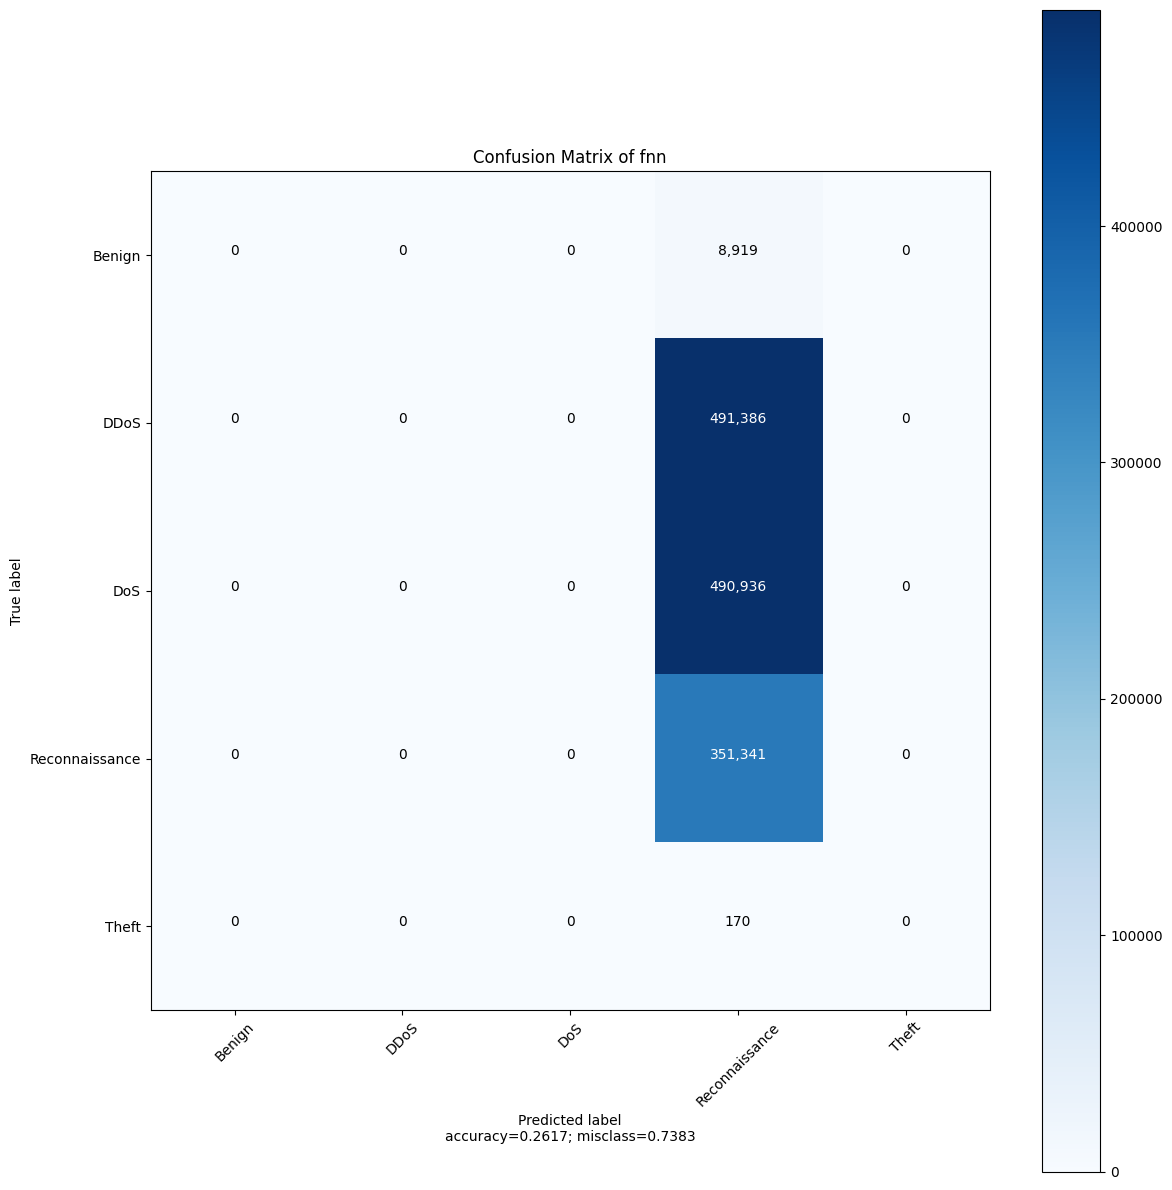

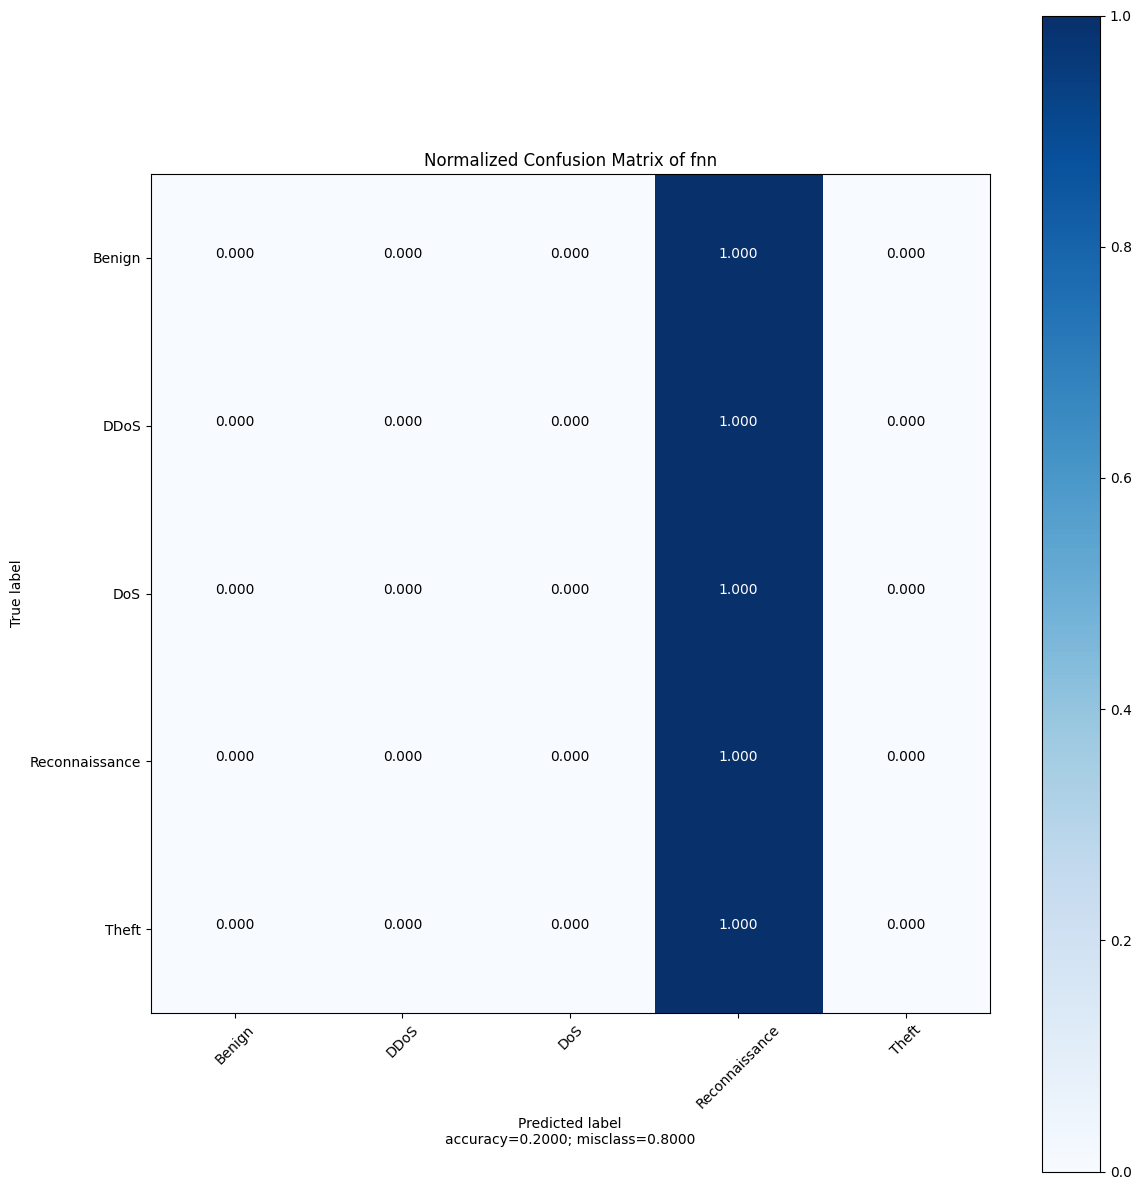

In [30]:
for m in my_models:
    train_model(m, X_train,
                y_train.to_numpy(),
                X_val,
                y_val.to_numpy())
    actual, test_pred, cm, cm_normalized = test_model(m, X_test, y_test.to_numpy())
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title=f"Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
    plot_confusion_matrix(cm=cm_normalized,
                          normalize=False,
                          normalized=True,
                          target_names=labels,
                          title=f"Normalized Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
    with open(os.path.join(folder_path, "actual.json"), "w") as f:
        f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
        f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, "results.json"), "w") as f:
        f.writelines(json.dumps(results_final, cls=NumpyEncoder))

In [31]:
# for m in my_models:
    
#     m.best_model.load_state_dict(th.load(f"temp/best_model_{m.model_name}.pth"))
        
#     actual, test_pred, cm, cm_normalized = test_model(m, X_test, y_test.to_numpy())
#     plot_confusion_matrix(cm=cm,
#                           normalize=False,
#                           target_names=labels,
#                           title=f"Confusion Matrix of {m.model_name}",
#                           file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
#     plot_confusion_matrix(cm=cm_normalized,
#                           normalize=False,
#                           normalized=True,
#                           target_names=labels,
#                           title=f"Normalized Confusion Matrix of {m.model_name}",
#                           file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
#     with open(os.path.join(folder_path, "actual.json"), "w") as f:
#         f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
#     with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
#         f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
#     with open(os.path.join(folder_path, "results.json"), "w") as f:
#         f.writelines(json.dumps(results_final, cls=NumpyEncoder))